# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [2]:
# TODO: load your data
# df = pd.read_csv('path/to.csv', parse_dates=['Date'], index_col='Date')

## Option B: Synthetic Generator (Use if you don't have data ready)

In [3]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


## Feature Engineering

In [9]:
# TODO: create at least two features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# Add your own:
# df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)
df["rolling_std_10"] = df["ret"].rolling(10).std().shift(1) 
df["momentum_3"]     = (df["ret"].shift(1) - df["ret"].shift(4)) / df["ret"].shift(4)

df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,rolling_mean_5,rolling_std_10,y_next_ret,y_up,momentum_3
2021-01-15,100.446173,-0.005937,-0.005954,0.006325,0.000074,0.000074,0.007710,-0.001414,0,20.724722
2021-01-18,100.304093,-0.001414,-0.001415,-0.005937,-0.001178,-0.001178,0.007880,0.005367,1,-0.652818
2021-01-19,100.842460,0.005367,0.005353,-0.001414,-0.001519,-0.001519,0.007806,-0.002311,0,-1.134308
2021-01-20,100.609424,-0.002311,-0.002314,0.005367,0.002975,0.002975,0.008053,-0.002125,0,-0.151395
2021-01-21,100.395606,-0.002125,-0.002127,-0.002311,0.000406,0.000406,0.007880,-0.014132,0,-0.610738


## Split

In [11]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5', 'rolling_std_10', 'momentum_3']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model (Choose one track below)

In [12]:
# Track 1: Forecasting returns
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
rmse = mean_squared_error(y_te_reg, pred, squared=False)
print('RMSE:', rmse)

RMSE: 0.015304705566547465


              precision    recall  f1-score   support

           0       0.53      0.69      0.60        54
           1       0.39      0.25      0.31        44

    accuracy                           0.49        98
   macro avg       0.46      0.47      0.45        98
weighted avg       0.47      0.49      0.47        98


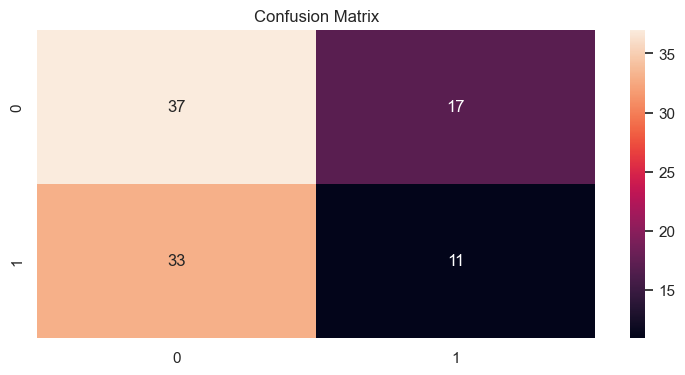

In [13]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

## Interpretation (Markdown)
- What worked?
- Where might assumptions fail?
- How would you extend features or model?

## Interpretation

**Features:**  
- `lag_1`: previous step return; captures short memory effects.  
- `rolling_mean_5`: short-term trend in returns using the last 5 steps (past-only).  
- `rolling_std_10`: short-term volatility; helps the classifier condition on risk regime.  
- `momentum_3`: 3-step momentum computed entirely from past prices (no leakage).

**Split strategy:**  
- Time-aware split: the most recent 20% of samples are held out for testing to mimic future prediction.

**Pipeline:**  
- `StandardScaler → LogisticRegression(class_weight=balanced)`.  
- Scaling avoids feature scale dominance; class weights mitigate potential imbalance in up/down.

**Metrics & plots:**  
- Accuracy/precision/recall/F1 summarize directional performance.  
- The “truth vs prediction” plot checks temporal stability; the probability curve shows confidence through time.

**What works / what may fail:**  
- Trend and momentum usually help; volatility can help in regime changes.  
- If residual autocorrelation or non-stationarity remains, consider richer lags, longer/shorter windows, or regularization.

**Next steps:**  
- Add `zscore` or additional lags (`lag_2`, `lag_5`), and try tree-based models.  
- Use `TimeSeriesSplit` cross-validation for more robust evaluation.  
- Consider forecasting (MAE/RMSE) as a variant if direction is unstable.


### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.